# AIR QUALITY

0 Date (DD/MM/YYYY)

1 Time (HH.MM.SS)

2 True hourly averaged concentration CO in mg/m^3 (reference analyzer)

3 PT08.S1 (tin oxide) hourly averaged sensor response (nominally CO targeted)

4 True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer)

5 True hourly averaged Benzene concentration in microg/m^3 (reference analyzer)

6 PT08.S2 (titania) hourly averaged sensor response (nominally NMHC targeted)

7 True hourly averaged NOx concentration in ppb (reference analyzer)

8 PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally NOx targeted)

9 True hourly averaged NO2 concentration in microg/m^3 (reference analyzer)

10 PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted)

11 PT08.S5 (indium oxide) hourly averaged sensor response (nominally O3 targeted)

12 Temperature in Â°C

13 Relative Humidity (%)

14 AH Absolute Humidity

In [15]:
import os
import numpy
import pandas
from matplotlib import pyplot
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [16]:
working_dir = os.getcwd()
notebooks_dir = os.path.dirname(working_dir)
root_dir = os.path.dirname(notebooks_dir)
data_dir = os.path.join(root_dir, 'datasets')
air_quality_file = os.path.join(data_dir, 'air_quality.csv')
df = pandas.read_csv(air_quality_file, sep=';', decimal=',')

df['Date'] = pandas.to_datetime(df['Date'], format='%d/%m/%Y')
df.loc[df['T'] == -200, 'T'] = numpy.nan
df.loc[df['RH'] < 0.0, 'RH'] = numpy.nan
df.loc[df['AH'] < 0.0, 'AH'] = numpy.nan
df_day = df[['Date', 'T', 'RH', 'AH']].groupby('Date').mean()

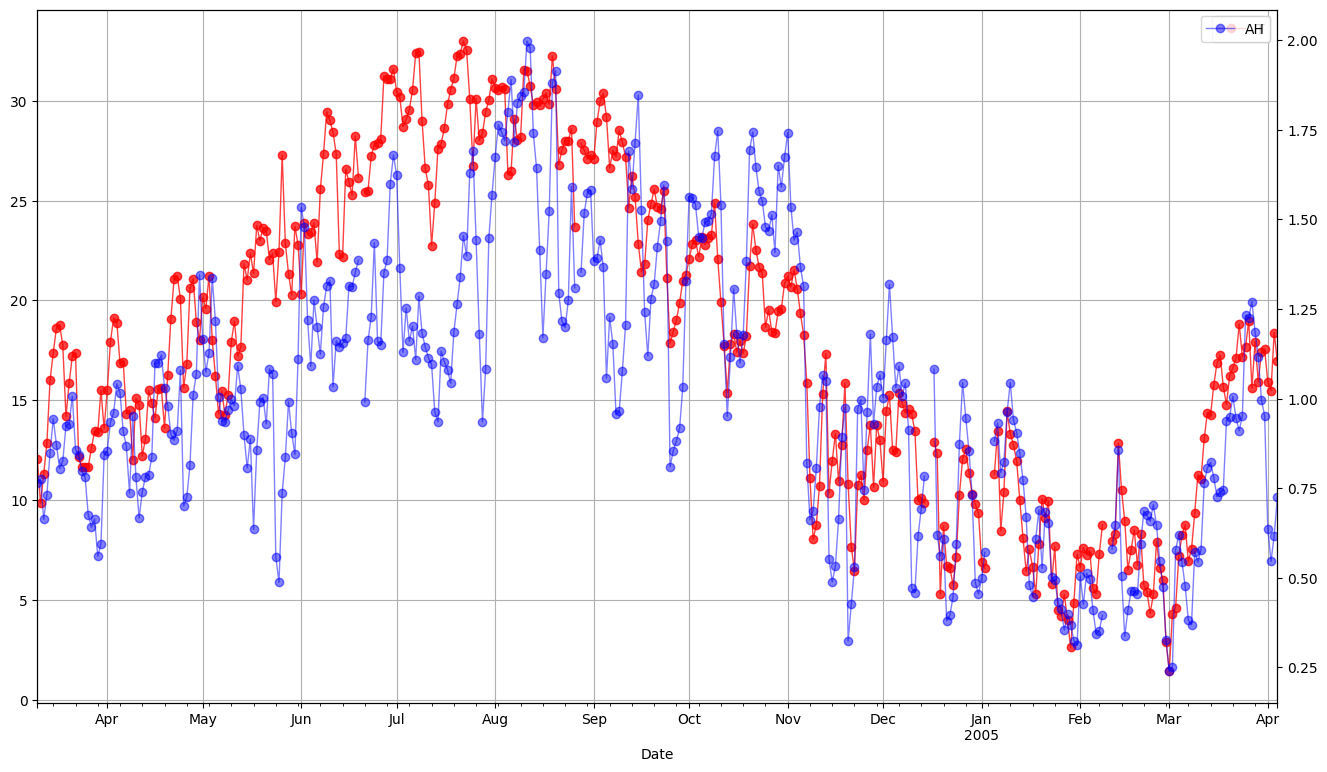

In [17]:
fig = pyplot.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
_ = df_day.plot(y='AH', ax=ax2, lw=1, marker='o', color='blue', alpha=0.5, legend="bottom right")
_ = df_day.plot(y='T', ax=ax, lw=1, marker='o', color='red', alpha=0.75)
_ = ax.grid()

In [18]:
df_day['T_d1'] = df_day['T'].shift(-1)
df_day['T_l1'] = df_day['T'].shift(1)
df_day['T_l2'] = df_day['T'].shift(2)
df_day['T_l3'] = df_day['T'].shift(3)
df_day['RH_l1'] = df_day['RH'].shift(1)
df_day['RH_l2'] = df_day['RH'].shift(2)
df_day['RH_l3'] = df_day['RH'].shift(3)
df_day['AH_l1'] = df_day['AH'].shift(1)
df_day['AH_l2'] = df_day['AH'].shift(2)
df_day['AH_l3'] = df_day['AH'].shift(3)
complete_cases = ~df_day.isna().any(axis=1)
dfn = df_day[complete_cases]

In [19]:
dfn

,T,RH,AH,T_d1,T_l1,T_l2,T_l3,RH_l1,RH_l2,RH_l3,AH_l1,AH_l2,AH_l3
Date,,,,,,,,,,,,,
2004-03-13,12.866667,51.533333,0.732296,16.012500,11.287500,9.837500,12.033333,51.095833,64.075000,54.900000,0.663104,0.775767,0.765633
2004-03-14,16.012500,48.850000,0.849671,17.366667,12.866667,11.287500,9.837500,51.533333,51.095833,64.075000,0.732296,0.663104,0.775767
2004-03-15,17.366667,50.320833,0.944029,18.625000,16.012500,12.866667,11.287500,48.850000,51.533333,51.095833,0.849671,0.732296,0.663104
2004-03-16,18.625000,44.837500,0.871021,18.779167,17.366667,16.012500,12.866667,50.320833,48.850000,51.533333,0.944029,0.849671,0.732296
2004-03-17,18.779167,41.166667,0.804917,17.762500,18.625000,17.366667,16.012500,44.837500,50.320833,48.850000,0.871021,0.944029,0.849671
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-03-30,17.433333,54.037500,0.996762,17.550000,15.916667,17.933333,15.612500,62.537500,60.766667,72.450000,1.116463,1.186071,1.270142
2005-03-31,17.550000,50.083333,0.951917,15.929167,17.433333,15.916667,17.933333,54.037500,62.537500,60.766667,0.996762,1.116463,1.186071
2005-04-01,15.929167,35.962500,0.636529,15.483333,17.550000,17.433333,15.916667,50.083333,54.037500,62.537500,0.951917,0.996762,1.116463


In [20]:
# TRAINING
n_test_samples = 30
n_validation_samples = 30
random_seed = 32

# SET THE RANDOM SEED
numpy.random.seed(random_seed)

x_cols = ['T', 'T_l1','T_l2','T_l3', 'AH_l1','AH_l2','AH_l3', 'RH_l1','RH_l2','RH_l3']
y_cols = ['T_d1']

# SAMPLING
X_trn = dfn.iloc[:-(n_validation_samples + n_test_samples)][x_cols].to_numpy()
X_val = dfn.iloc[-(n_validation_samples + n_test_samples):-n_test_samples][x_cols].to_numpy()
X_tst = dfn[x_cols].to_numpy()
Y_trn = dfn.iloc[:-(n_validation_samples + n_test_samples)][y_cols].to_numpy()
Y_val = dfn.iloc[-(n_validation_samples + n_test_samples):-n_test_samples][y_cols].to_numpy()

# SCALING X
X_scaler = StandardScaler()
X_scaler = X_scaler.fit(X_trn)
X_trn_scaled = X_scaler.transform(X_trn)
X_val_scaled = X_scaler.transform(X_val)
X_tst_scaled = X_scaler.transform(X_tst)

# SCALING Y
Y_scaler = StandardScaler()
Y_scaler = Y_scaler.fit(Y_trn)
Y_trn_scaled = Y_scaler.transform(Y_trn)
Y_val_scaled = Y_scaler.transform(Y_val)

In [21]:
linreg = linear_model.LinearRegression()
_ = linreg.fit(X_trn_scaled, Y_trn_scaled)

Y_est_linreg_scaled = linreg.predict(X_tst_scaled)
Y_est_linreg = Y_scaler.inverse_transform(Y_est_linreg_scaled)
df_day['T_d1_linreg'] = numpy.nan
df_day.loc[complete_cases, 'T_d1_linreg'] = Y_est_linreg
df_day['residual_linreg'] = df_day['T_d1'] - df_day['T_d1_linreg']
df_day['rabs_linreg'] = df_day['residual_linreg'].abs()
linreg_r2 = r2_score(df_day.loc[complete_cases, 'T_d1'], df_day.loc[complete_cases, 'T_d1_linreg'])
print(f"Linear Regression R2: {linreg_r2}")

Linear Regression R2: 0.9446268583768662


In [22]:
lassoreg = linear_model.Lasso(alpha=0.1)
_ = lassoreg.fit(X_trn_scaled, Y_trn_scaled)

Y_est_lassoreg_scaled = lassoreg.predict(X_tst_scaled)
Y_est_lassoreg = Y_scaler.inverse_transform(Y_est_lassoreg_scaled.reshape(-1, 1))
df_day['T_d1_lassoreg'] = numpy.nan
df_day.loc[complete_cases, 'T_d1_lassoreg'] = Y_est_lassoreg
df_day['residual_lassoreg'] = df_day['T_d1'] - df_day['T_d1_lassoreg']
df_day['rabs_lassoreg'] = df_day['residual_lassoreg'].abs()
lassoreg_r2 = r2_score(df_day.loc[complete_cases, 'T_d1'], df_day.loc[complete_cases, 'T_d1_lassoreg'])
print(f"Lasso Regression R2: {lassoreg_r2}")

Lasso Regression R2: 0.9322942424766303


In [23]:
optimal_lasso = linear_model.LassoCV(cv=5, random_state=random_seed)
_ = optimal_lasso.fit(X_trn_scaled, Y_trn_scaled.ravel())
print(f"Optimal Lasso Alpha: {optimal_lasso.alpha_}")

optimal_lassoreg = linear_model.Lasso(alpha=optimal_lasso.alpha_)
_ = optimal_lassoreg.fit(X_trn_scaled, Y_trn_scaled)
df_day['T_d1_optimal_lassoreg'] = numpy.nan
df_day.loc[complete_cases, 'T_d1_optimal_lassoreg'] = Y_scaler.inverse_transform(optimal_lassoreg.predict(X_tst_scaled).reshape(-1, 1))
df_day['residual_optimal_lassoreg'] = df_day['T_d1'] - df_day['T_d1_optimal_lassoreg']
df_day['rabs_optimal_lassoreg'] = df_day['residual_optimal_lassoreg'].abs()
optimal_lassoreg_r2 = r2_score(df_day.loc[complete_cases, 'T_d1'], df_day.loc[complete_cases, 'T_d1_optimal_lassoreg'])
print(f"Optimal Lasso Regression R2: {optimal_lassoreg_r2}")

Optimal Lasso Alpha: 0.001367313455008545
Optimal Lasso Regression R2: 0.944787653478721


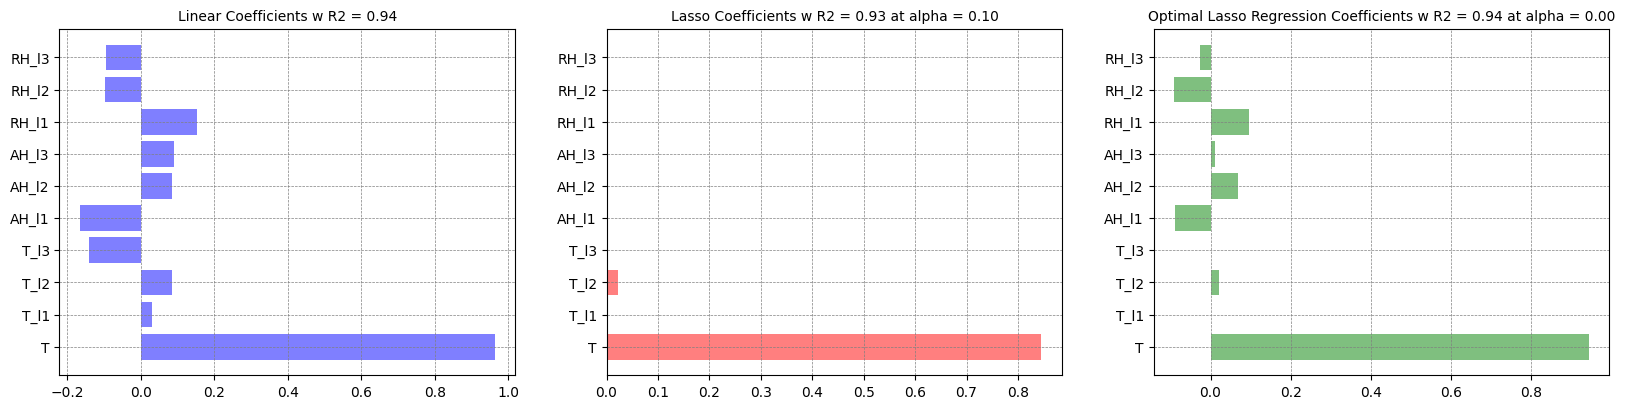

In [24]:
# PLOT LINREG VS LASSOREG COEFFICIENTS
fig = pyplot.figure(figsize=(20, 4.5))
ax = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
_ = ax.barh(x_cols, linreg.coef_.flatten(), color='blue', alpha=0.5)
_ = ax2.barh(x_cols, lassoreg.coef_.flatten(), color='red', alpha=0.5)
_ = ax3.barh(x_cols, optimal_lassoreg.coef_.flatten(), color='green', alpha=0.5)
_ = ax.set_title(f'Linear Coefficients w R2 = {linreg_r2:.2f}', fontsize=10)
_ = ax2.set_title(f'Lasso Coefficients w R2 = {lassoreg_r2:.2f} at alpha = {lassoreg.alpha:.2f}', fontsize=10)
_ = ax3.set_title(f'Optimal Lasso Regression Coefficients w R2 = {optimal_lassoreg_r2:.2f} at alpha = {optimal_lasso.alpha_:.2f}', fontsize=10)
_ = ax.grid(which='both', color='gray', linestyle='--', linewidth=0.5)
_ = ax2.grid(which='both', color='gray', linestyle='--', linewidth=0.5)
_ = ax3.grid(which='both', color='gray', linestyle='--', linewidth=0.5)

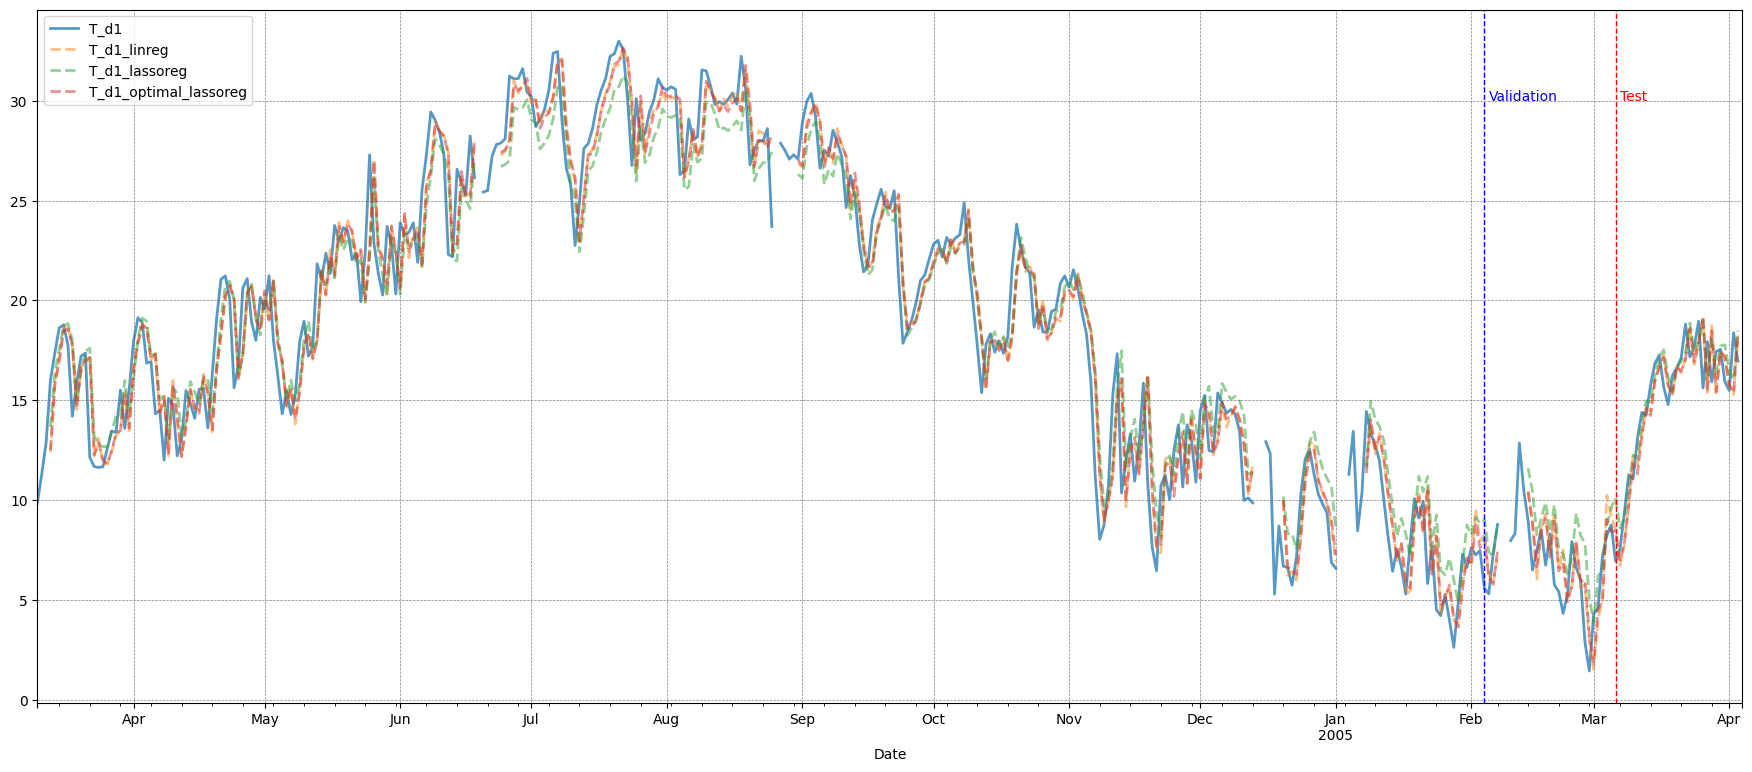

In [25]:
fig = pyplot.figure(figsize=(22, 9))
ax = fig.add_subplot(111)
_ = df_day.plot(y='T_d1', ax=ax, lw=2, alpha=0.75)
_ = df_day.plot(y='T_d1_linreg', ax=ax, lw=2, alpha=0.5, ls='--')
_ = df_day.plot(y='T_d1_lassoreg', ax=ax, lw=2, alpha=0.5, ls='--')
_ = df_day.plot(y='T_d1_optimal_lassoreg', ax=ax, lw=2, alpha=0.5, ls='--')
_ = ax.grid(which='major', color='gray', linestyle='--', linewidth=0.5)
# PLOT A VERTICAL LINE TO SEPARATE TRAINING FROM VALIDATION AND TESTING
_ = ax.axvline(x=df_day.index[-(n_validation_samples + n_test_samples)], color='blue', linestyle='--', linewidth=1)
_ = ax.axvline(x=df_day.index[-n_test_samples], color='red', linestyle='--', linewidth=1)
# PLOT VALIDATION AND TEST ANNOTATIONS
_ = ax.annotate('Validation', xy=(df_day.index[-(n_validation_samples + n_test_samples)] + pandas.Timedelta(days=1), 30), color='blue')
_ = ax.annotate('Test', xy=(df_day.index[-n_test_samples] + pandas.Timedelta(days=1), 30), color='red')
_ = ax.legend(['T_d1', 'T_d1_linreg', 'T_d1_lassoreg', 'T_d1_optimal_lassoreg'])


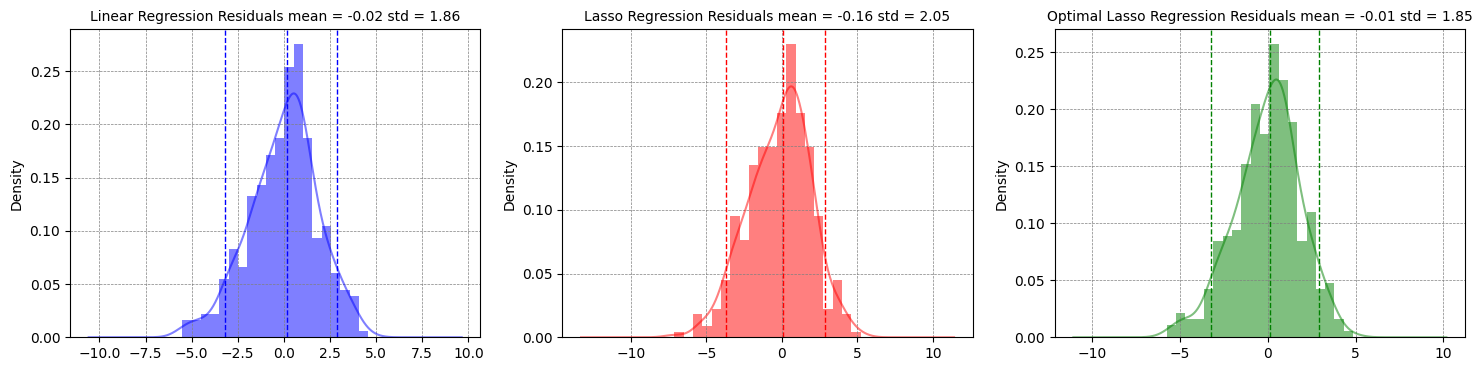

In [26]:
# RESIDUAL VS KDE VS STATISTICS
fig = pyplot.figure(figsize=(18, 4))
ax_linreg = fig.add_subplot(131)
ax_lassoreg = fig.add_subplot(132)
ax_optimal_lassoreg = fig.add_subplot(133)
_ = df_day['residual_linreg'].plot.hist(ax=ax_linreg, color='blue', alpha=0.5, bins=20, density=True)
_ = df_day['residual_linreg'].plot.kde(ax=ax_linreg, color='blue', alpha=0.5)
_ = df_day['residual_lassoreg'].plot.hist(ax=ax_lassoreg, color='red', alpha=0.5, bins=20, density=True)
_ = df_day['residual_lassoreg'].plot.kde(ax=ax_lassoreg, color='red', alpha=0.5)
_ = df_day['residual_optimal_lassoreg'].plot.hist(ax=ax_optimal_lassoreg, color='green', alpha=0.5, bins=20, density=True)
_ = df_day['residual_optimal_lassoreg'].plot.kde(ax=ax_optimal_lassoreg, color='green', alpha=0.5)
_ = ax_linreg.grid(which='both', color='gray', linestyle='--', linewidth=0.5)
_ = ax_lassoreg.grid(which='both', color='gray', linestyle='--', linewidth=0.5)
_ = ax_optimal_lassoreg.grid(which='both', color='gray', linestyle='--', linewidth=0.5)
_ = ax_linreg.set_title(f'Linear Regression Residuals mean = {df_day["residual_linreg"].mean():.2f} std = {df_day["residual_linreg"].std():.2f}', fontsize=10)
_ = ax_lassoreg.set_title(f'Lasso Regression Residuals mean = {df_day["residual_lassoreg"].mean():.2f} std = {df_day["residual_lassoreg"].std():.2f}', fontsize=10)
_ = ax_optimal_lassoreg.set_title(f'Optimal Lasso Regression Residuals mean = {df_day["residual_optimal_lassoreg"].mean():.2f} std = {df_day["residual_optimal_lassoreg"].std():.2f}', fontsize=10)
_ = ax_linreg.axvline(df_day['residual_linreg'].quantile(0.05), color='blue', linestyle='--', linewidth=1)
_ = ax_linreg.axvline(df_day['residual_linreg'].quantile(0.5), color='blue', linestyle='--', linewidth=1)
_ = ax_linreg.axvline(df_day['residual_linreg'].quantile(0.95), color='blue', linestyle='--', linewidth=1)
_ = ax_lassoreg.axvline(df_day['residual_lassoreg'].quantile(0.05), color='red', linestyle='--', linewidth=1)
_ = ax_lassoreg.axvline(df_day['residual_lassoreg'].quantile(0.5), color='red', linestyle='--', linewidth=1)
_ = ax_lassoreg.axvline(df_day['residual_lassoreg'].quantile(0.95), color='red', linestyle='--', linewidth=1)
_ = ax_optimal_lassoreg.axvline(df_day['residual_optimal_lassoreg'].quantile(0.05), color='green', linestyle='--', linewidth=1)
_ = ax_optimal_lassoreg.axvline(df_day['residual_optimal_lassoreg'].quantile(0.5), color='green', linestyle='--', linewidth=1)
_ = ax_optimal_lassoreg.axvline(df_day['residual_optimal_lassoreg'].quantile(0.95), color='green', linestyle='--', linewidth=1)
